In [8]:
import openmc
import matplotlib.pyplot as plt
import numpy as np

In [9]:
#Lupin materials

#lead casing
lead = openmc.Material(name='lead')
lead.add_element('Pb', 1, 'ao')
#aluminium shell
al = openmc.Material(name='aluminium')
al.add_element('Al', 1, 'ao')
#cadmium 
cadmium = openmc.Material(name='cadmium')
cadmium.add_element('Cd', 1, 'ao')
#BF3
bf3 = openmc.Material(name='bf3')
bf3.add_elements_from_formula('BF3')
#polyethylene
polyethylene = openmc.Material(name='polyethylene')
polyethylene.add_elements_from_formula('C2H4')
polyethylene.set_density('kg/m3',940)
mats = openmc.Materials([al, bf3, polyethylene])

In [10]:
"""#lupin geometry
cylinder_radius = 0.054
detector_radius = 0.0215
detector_height = 0.0455
cylinder_height = 0.297

inner_polyethylene_cylinder = openmc.ZCylinder(r=cylinder_radius)
detector_cylinder = openmc.ZCylinder(r=detector_radius)

top_cylinder = openmc.ZPlane(z0=cylinder_height*0.5)
bottom_cylinder = openmc.ZPlane(z0=-cylinder_height*0.5)

bottom_detector = openmc.ZPlane(z0=0.5*(-cylinder_height+detector_height))


top_region = -inner_polyethylene_cylinder & +detector_cylinder & +bottom_detector & -top_cylinder
bottom_region = -inner_polyethylene_cylinder & +bottom_cylinder & -bottom_detector

inner_polyethylene_cell = openmc.Cell(region=top_region | bottom_region)

universe = openmc.Universe(cells=[inner_polyethylene_cell])

x,y = 0.4,0.4

plt.show(universe.plot(width=(x, y), basis='xz'))
plt.show(universe.plot(width=(x, y), basis='xy'))
plt.show(universe.plot(width=(x, y), basis='yz'))"""

"#lupin geometry\ncylinder_radius = 0.054\ndetector_radius = 0.0215\ndetector_height = 0.0455\ncylinder_height = 0.297\n\ninner_polyethylene_cylinder = openmc.ZCylinder(r=cylinder_radius)\ndetector_cylinder = openmc.ZCylinder(r=detector_radius)\n\ntop_cylinder = openmc.ZPlane(z0=cylinder_height*0.5)\nbottom_cylinder = openmc.ZPlane(z0=-cylinder_height*0.5)\n\nbottom_detector = openmc.ZPlane(z0=0.5*(-cylinder_height+detector_height))\n\n\ntop_region = -inner_polyethylene_cylinder & +detector_cylinder & +bottom_detector & -top_cylinder\nbottom_region = -inner_polyethylene_cylinder & +bottom_cylinder & -bottom_detector\n\ninner_polyethylene_cell = openmc.Cell(region=top_region | bottom_region)\n\nuniverse = openmc.Universe(cells=[inner_polyethylene_cell])\n\nx,y = 0.4,0.4\n\nplt.show(universe.plot(width=(x, y), basis='xz'))\nplt.show(universe.plot(width=(x, y), basis='xy'))\nplt.show(universe.plot(width=(x, y), basis='yz'))"

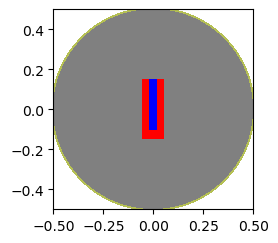

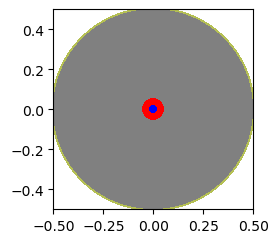

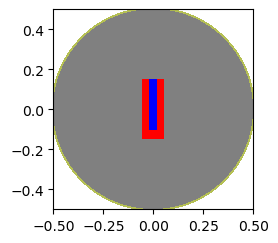

In [11]:
cylinder_radius = 0.054
cylinder_height = 0.297
shielding_thickness = 0.0015
detector_radius = 0.02
detector_height = 0.0455
source_distance = 0.5

source_sphere = openmc.Sphere(r=source_distance)
outer_void = openmc.Sphere(r=source_distance + 0.01, boundary_type='vacuum')
cylinder = openmc.ZCylinder(r=cylinder_radius)
shielding = openmc.ZCylinder(r=detector_radius+shielding_thickness)
detector = openmc.ZCylinder(r=detector_radius)


top_cylinder = openmc.ZPlane(z0=0.5*cylinder_height)
bottom_cylinder = openmc.ZPlane(z0=-0.5*cylinder_height)
bottom_detector = openmc.ZPlane(z0=-0.5*cylinder_height+detector_height)
bottom_al = openmc.ZPlane(z0=-0.5*cylinder_height+detector_height-shielding_thickness)

b_cylinder_r = -cylinder & -bottom_al & +bottom_cylinder
outer_top = openmc.ZPlane(z0=(cylinder_height*0.5)+0.01)
top_cap_region =  -outer_top & +top_cylinder & -shielding
top_cap_cell = openmc.Cell(region=top_cap_region)

outer_void_cell = openmc.Cell(region= +source_sphere & -outer_void)

sphere_region = (-source_sphere & +cylinder) | (-cylinder & -source_sphere &+top_cylinder) | (-cylinder & -source_sphere & -bottom_cylinder)
shielding_region = (-shielding & -top_cylinder & +bottom_al & +detector) | (-detector & -bottom_detector & +bottom_al)
poly_region = (-cylinder & -top_cylinder & +bottom_cylinder & +shielding) | b_cylinder_r
detector_region = -detector & -top_cylinder & +bottom_detector

sphere_cell = openmc.Cell(region=sphere_region)
shielding_cell = openmc.Cell(region=shielding_region, fill = al)
detector_cell = openmc.Cell(region=detector_region, fill =bf3)
poly_cell = openmc.Cell(region=poly_region, fill = polyethylene)

universe = openmc.Universe(cells=[sphere_cell, shielding_cell, detector_cell, poly_cell, outer_void_cell])
geom = openmc.Geometry(universe)
x,y = 1,1
colour_assignment = {sphere_cell: 'grey', shielding_cell: 'black', detector_cell: 'blue', poly_cell: 'red'}
plt.show(universe.plot(width=(x, y), basis='xz', colors=colour_assignment))
plt.show(universe.plot(width=(x, y), basis='xy', colors=colour_assignment))
plt.show(universe.plot(width=(x, y), basis='yz', colors=colour_assignment))

In [12]:
import openmc
import openmc_plotter



In [13]:
#settings
import openmc_source_plotter as osp

sett = openmc.Settings()
sett.batches = 5
sett.inactive = 0
sett.particles = 10000
sett.run_mode = 'fixed source'

#source
sphere_source = openmc.Source()
sphere_source.angle = openmc.stats.Isotropic()
sphere_source.energy = openmc.stats.Discrete([14e6], [1])
sphere_source.space = openmc.stats.spherical_uniform(r_outer=source_distance, r_inner=source_distance)
sphere_source.particle = 'neutron'
sett.source = sphere_source

#plot = sphere_source.plot_source_position(n_samples=5000)
#plot.show()

In [14]:
#tallies
tallies = openmc.Tallies()

energy_filter = openmc.EnergyFilter(np.linspace(0,15e6,200))
neutron_filter = openmc.ParticleFilter(['neutron'])
detector_cell_filter = openmc.CellFilter(detector_cell)

detector_tally = openmc.Tally()
detector_tally.filters = [energy_filter, neutron_filter, detector_cell_filter]
detector_tally.scores = ['flux']
tallies.append(detector_tally)

In [15]:
# combine all the required parts to make a model
model = openmc.model.Model(geom, mats, sett, tallies)

# remove old files and runs OpenMC
!rm *.h5
results_filename = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [23]:
sp = openmc.StatePoint(results_filename)
tally  = sp.get_tally(name='detector_tally')

LookupError: Unable to get Tally

In [20]:
#print geometry
vox_plot = openmc.Plot()
vox_plot.type = 'voxel'
vox_plot.width = (0.1,0.1,0.6)
vox_plot.pixels = (500,500,500)
vox_plot.filename = 'plot_lupin_geom'
vox_plot.color_by = 'material'
vox_plot.colors = {bf3: 'blue', al: 'black', polyethylene: 'green'}
plots = openmc.Plots([vox_plot])
plots.export_to_xml()
openmc.plot_geometry()

import os
os.system('openmc-voxel-to-vtk plot_lupin_geom.h5 -o plot_lupin_geom.vti')

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

0